# Análisis Exploratorio de Datos (EDA)


En este cuaderno de trabajo, se realizará un análisis exploratorio de los datos con el fin de obtener insumos que sean de utilidad para la realización de la segunda fase de CRISP-DM, que corresponde a entendimiento de los datos.

El objetivo de este cuaderno es obtener información sobre los datos:

- **Estructura de los archivos de medición**
- **Estructura de los datos** 
- **Calidad de los datos**
- **Completitud de los datos**
- **Variables disponibles**

El presente cuaderno de trabajo contiene cuatro secciones:
1. **Exploración de los datos**
2. **Análisis de calidad de los datos** 
3. **Comparación entre normalización anual y normalización por día**
4. **Importancia del ajuste realizado a las curvas para comparabilidad**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()

import sys
import os

ruta_src = os.path.abspath("../utils")
sys.path.append(ruta_src)
ruta_imgs_latex = os.path.abspath("../latex/imgs")
sys.path.append(ruta_imgs_latex)

from utilities import *

warnings.filterwarnings("ignore")

## 1.- Exploración de los datos

#### Lectura de los datos del grupo 01

In [2]:
mediciones_clientes_g1 = r"../data/mediciones_por_mes_g1"
archivos_mediciones_g1 = list(os.scandir(mediciones_clientes_g1))
columnas_extraer_g1 = ["Fecha","Demanda activa DEL","Demanda reactiva DEL"]

In [3]:
clientes_unicos_g1 = set()

for medicion in archivos_mediciones_g1:
    cliente = medicion.name.split('-')[1]
    clientes_unicos_g1.add(cliente)

print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(clientes_unicos_g1)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 313


In [4]:
# Diccionario para almacenar los clientes con sus respectivos datos
dict_dfs_clientes_g1 = {}

# Iterar sobre cada cliente
for cliente in tqdm(clientes_unicos_g1, desc="Procesando clientes del grupo 01"):
    datos_cliente = []
    # Iterar sobre cada archivo de medicion del grupo 01
    for medicion in archivos_mediciones_g1:
        if cliente == medicion.name.split("-")[1]:
            df_cliente = intentar_abrir_archivo_datos(f"{mediciones_clientes_g1}/{medicion.name}")
            datos_cliente.extend(df_cliente[columnas_extraer_g1].values)

    # Convertir a DataFrame los datos concatenados
    df_datos_anual_cliente = pd.DataFrame(datos_cliente, columns=columnas_extraer_g1)
    
    # Almacenar en el diccionario (Clave->Cliente   Valor->DataFrame)
    dict_dfs_clientes_g1[cliente]=df_datos_anual_cliente
    
    # Eliminar dataframe concatenado para liberar memoria
    del df_datos_anual_cliente
    #df_datos_anual_cliente.to_csv(f"mediciones_por_anio/g1_perfil_carga_anual-{cliente}-2023.csv", index=False)

Procesando clientes del grupo 01: 100%|██████████| 313/313 [01:54<00:00,  2.73it/s]


#### Lectura de los datos del grupo 02

In [5]:
mediciones_clientes_g2 = "../data/mediciones_por_mes_g2"
archivos_mediciones_g2 = list(os.scandir(mediciones_clientes_g2))
columnas_extraer_g2 = ["Fecha", "AS (kWh)"]

In [6]:
print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(archivos_mediciones_g2)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 75


In [7]:
# Diccionario para almacenar los clientes con sus datos
dict_dfs_clientes_g2 = {}

# Iterar sobre cada cliente
for archivos_cliente in tqdm(archivos_mediciones_g2, desc="Procesando clientes del grupo 02"):
    nombre_cli = archivos_cliente.name.strip()
    df_concat = pd.DataFrame()

    # Obtener los archivos de las mediciones mensuales del cliente
    mediciones_mensuales_cliente = os.scandir(rf"{mediciones_clientes_g2}/{nombre_cli}")

    for medicion in mediciones_mensuales_cliente:
        medicion_mensual = pd.read_csv(rf"{mediciones_clientes_g2}/{nombre_cli}/{medicion.name}", sep=";", skiprows=2, encoding='ISO-8859-1')
        medicion_mensual = medicion_mensual[columnas_extraer_g2]
        df_concat = pd.concat([df_concat, medicion_mensual])

    # Almacenar en el diccionario (Clave->Cliente   Valor->DataFrame)
    dict_dfs_clientes_g2[nombre_cli] = df_concat
    
    # Eliminar dataframe concatenado para liberar memoria
    del df_concat
    #df_concat.to_csv(rf"mediciones_por_anio/g2_perfil_carga_anual-{nombre_cli}-2023.csv", index=False)

Procesando clientes del grupo 02: 100%|██████████| 75/75 [00:17<00:00,  4.25it/s]


#### Creación de una tabla resúmen

In [8]:
# """Detecta si las columnas representan energía o potencia a partir de los nombres de columna."""
def potencia_o_energia(df):
    
    cols = " ".join(map(str, df.columns)).lower()
    
    # Detectar si existen columnas de energía o potencia
    if 'kwh' in cols or '(kwh)' in cols or 'kw h' in cols:
        return 'Energía'
    if 'demanda' in cols or 'potencia' in cols or 'kw' in cols:
        return 'Potencias'
    
    return 'Desconocido'

# """Genera un DataFrame resumen con: cliente, intervalo_minutos, tipo_medicion, nro_registros."""
def creat_tabla_resumen(dict_dfs, group_name=None):
    
    rows = []
    for cliente, df in dict_dfs.items():
        df = df.reset_index(drop=True)
        df["Fecha"]=df["Fecha"].astype("string")
        df = df[~df["Fecha"].str.contains("Total")]
        try:
            primeros_minutos = int(str(df.loc[0,"Fecha"]).rsplit(':')[-1])
            segundos_minutos = int(str(df.loc[1,"Fecha"]).rsplit(':')[-1])
            if int(primeros_minutos) == 0 and segundos_minutos == 45:
                intervalo = abs(60-segundos_minutos)
            elif int(primeros_minutos) == 0 and segundos_minutos == 30:
                intervalo = abs(45-segundos_minutos)
            elif int(primeros_minutos) == 0 and segundos_minutos == 15:
                intervalo = abs(30-segundos_minutos)
            elif int(primeros_minutos) == 0 and segundos_minutos == 0:
                intervalo = abs(15-segundos_minutos)
            else:
                intervalo = abs(segundos_minutos-primeros_minutos)
                
            tipo = potencia_o_energia(df)
            nro = int(len(df))
        except Exception as e:
            print(f'Error procesando al cliente {cliente}')
            intervalo = np.nan
            tipo = 'Error'
            nro = 0
        rows.append({
            'cliente': cliente,
            'intervalo_minutos': intervalo,
            'tipo_medicion': tipo,
            'nro_registros': nro
        })
    return pd.DataFrame(rows)

# Generar resúmenes para los dos grupos ya cargados
summary_g1 = creat_tabla_resumen(dict_dfs_clientes_g1)
summary_g2 = creat_tabla_resumen(dict_dfs_clientes_g2)

# Concatenar y ordenar
summary_all = pd.concat([summary_g1, summary_g2], ignore_index=True)
summary_all['intervalo_minutos'] = summary_all['intervalo_minutos'].replace({np.nan: None})

# Guardar en variable global para uso posterior
resumen_mediciones_por_cliente = summary_all

print('Resumen generado. Filas:', len(summary_all))


Resumen generado. Filas: 388


In [9]:
resumen_mediciones_por_cliente

,cliente,intervalo_minutos,tipo_medicion,nro_registros
0,90002183,15,Potencias,29081
1,1224011,15,Potencias,30892
2,90000356,15,Potencias,30938
3,90001108,15,Potencias,32884
4,90001347,15,Potencias,30847
...,...,...,...,...
383,SIGMAPLAST,15,Energía,35040
384,SINTOFIL,15,Energía,35040
385,SOCIEDAD INDUSTRIAL RELI CYRANO,15,Energía,35040
386,TEXTILES TEXSA,15,Energía,32352


#### Gráficos que resumen exploración inicial de los datos

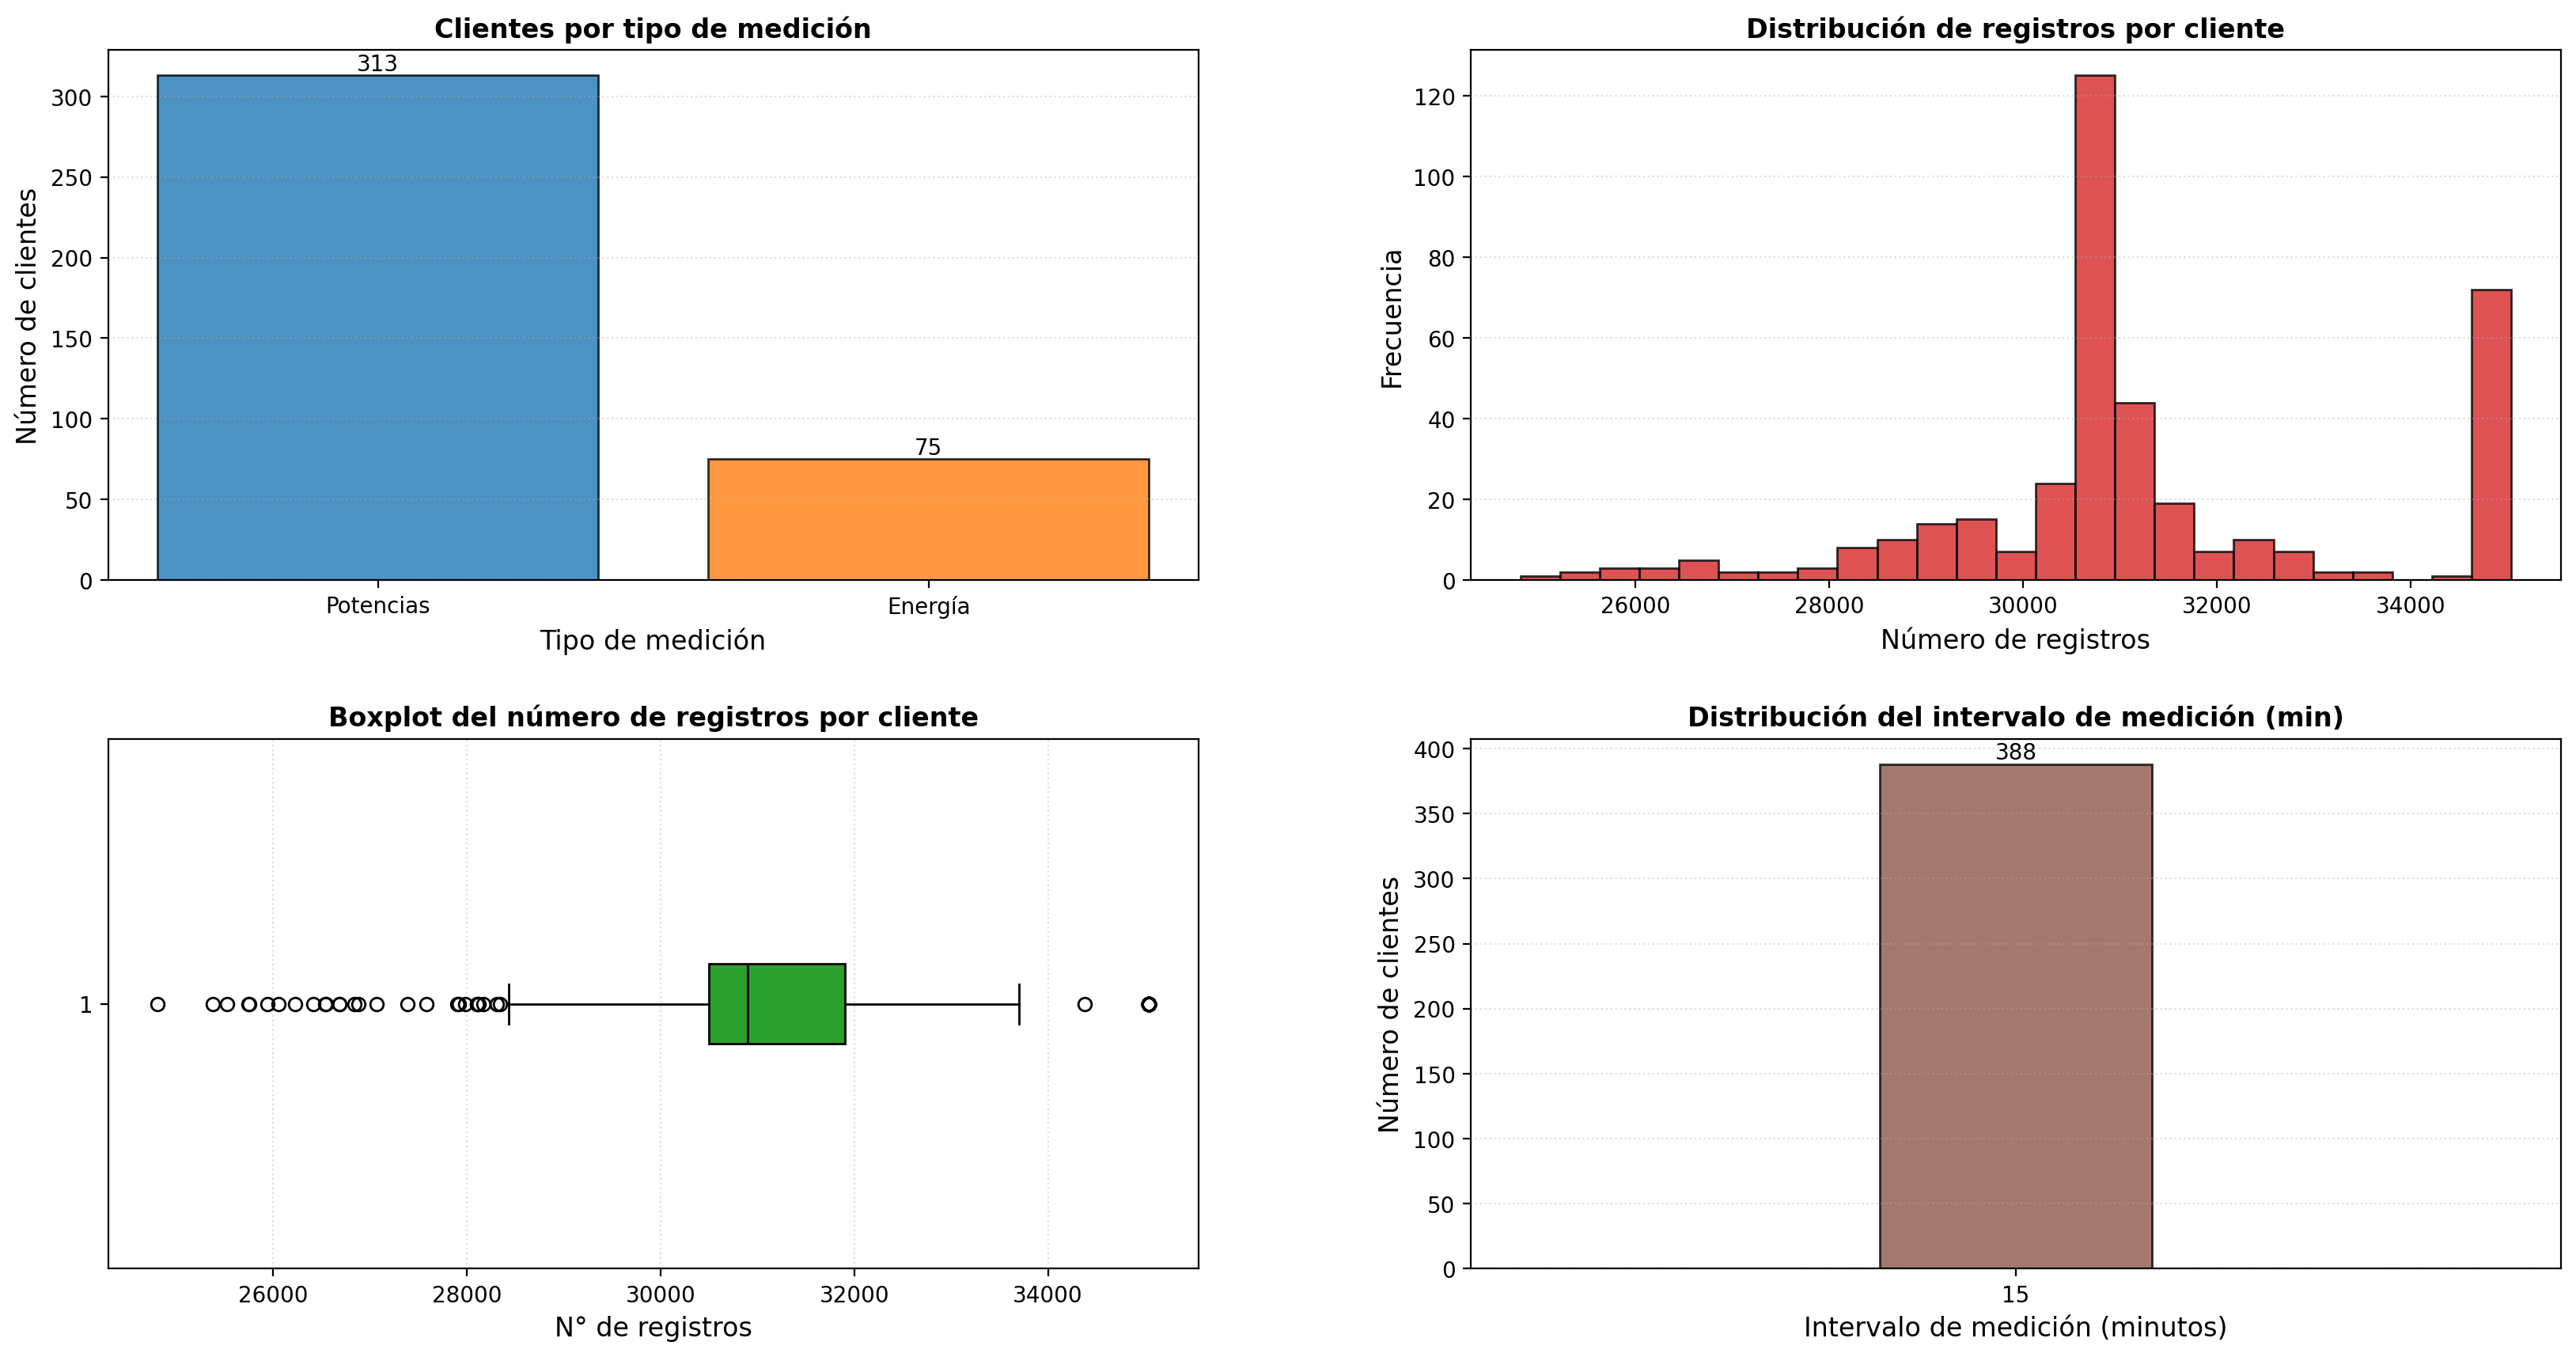

In [10]:
# Colores elegantes
colores = plt.cm.tab10.colors

# Figura general
fig, axes = plt.subplots(2, 2, figsize=(20, 10), dpi=200)
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# -------------------- 1. Barplot tipo_medicion --------------------
ax = axes[0, 0]
conteo_tipo = resumen_mediciones_por_cliente['tipo_medicion'].value_counts()
bars = ax.bar(conteo_tipo.index.astype(str), conteo_tipo.values, color=colores,edgecolor='black', alpha=0.8)

ax.set_title('Clientes por tipo de medición', fontsize=12, weight='bold')
ax.set_xlabel('Tipo de medición', fontsize=12)
ax.set_ylabel('Número de clientes', fontsize=12)
ax.grid(axis='y', linestyle=':', alpha=0.4)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{int(bar.get_height())}", ha='center', va='bottom', fontsize=10)

# -------------------- 2. Histograma nro_registros --------------------
ax = axes[0, 1]
ax.hist(resumen_mediciones_por_cliente['nro_registros'].dropna(),
        bins=25, edgecolor='black', alpha=0.8, color=colores[3])
ax.set_title('Distribución de registros por cliente', fontsize=12, weight='bold')
ax.set_xlabel('Número de registros', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.grid(axis='y', linestyle=':', alpha=0.4)

# -------------------- 3. Boxplot horizontal --------------------
ax = axes[1, 0]
ax.boxplot(resumen_mediciones_por_cliente['nro_registros'].dropna(),
           vert=False,
           patch_artist=True,
           boxprops=dict(facecolor=colores[2], color='black'),
           medianprops=dict(color='black'))
ax.set_title('Boxplot del número de registros por cliente', fontsize=12, weight='bold')
ax.set_xlabel('N° de registros', fontsize=12)
ax.grid(axis='x', linestyle=':', alpha=0.4)

# -------------------- 4. Barplot de intervalo (barra realmente más delgada y centrada) --------------------
ax = axes[1, 1]
conteo_intervalo = resumen_mediciones_por_cliente['intervalo_minutos'].value_counts()

# Crear posiciones manuales (por si luego hay más intervalos)
x_positions = np.arange(len(conteo_intervalo))

# Barra más delgada y centrada
bars_intervalo = ax.bar(x_positions,
                        conteo_intervalo.values,
                        width=0.3,       # ANCHO REAL DE LA BARRA
                        color=colores[5],
                        align='center',
                        edgecolor='black', alpha=0.8)

# Etiquetas y estilo
ax.set_title('Distribución del intervalo de medición (min)', fontsize=12, weight='bold')
ax.set_xlabel('Intervalo de medición (minutos)', fontsize=12)
ax.set_ylabel('Número de clientes', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels(conteo_intervalo.index.astype(str))

# Ajuste del eje X para evitar que la barra se vea gruesa
ax.set_xlim(-0.6, len(x_positions) - 0.4)

ax.grid(axis='y', linestyle=':', alpha=0.4)

# Etiquetas sobre barra
for bar in bars_intervalo:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{int(bar.get_height())}",
            ha='center', va='bottom', fontsize=10)

## 2.- Análisis de calidad de datos

In [11]:
IDEAL_REG_15MIN = 35040  # registros ideales (15 min * 24h * 365 días)
#plt.style.use('seaborn-v0_8-whitegrid')

# -----------------------------
# FUNCIONES AUXILIARES
# -----------------------------

def contar_coma_miles_en_df(df, columnas_numericas):
    """Cuenta registros que contienen coma como separador de miles."""
    if not columnas_numericas:
        return 0
    regex = re.compile(r'^\s*\d{1,3}(,\d{3})+(\.\d+)?\s*$')
    mask_total = pd.Series(False, index=df.index)
    for col in columnas_numericas:
        if col not in df.columns:
            continue
        s = df[col].astype(str)
        mask_col = s.str.match(regex, na=False)
        mask_total |= mask_col
    return int(mask_total.sum())

def clasificar_formato_fecha(serie_fecha):
    """Clasifica los formatos de fecha (cadena)."""
    serie_str = serie_fecha.astype(str).str.strip()
    parte_fecha = serie_str.str.split().str[0]
    formato = pd.Series('Sin identificar', index=parte_fecha.index)

    reglas = {
        'YYYY-MM-DD': r'^\d{4}-\d{1,2}-\d{1,2}$',
        'YYYY/MM/DD': r'^\d{4}/\d{1,2}/\d{1,2}$',
        'DD-MM-YYYY': r'^\d{1,2}-\d{1,2}-\d{4}$',
        'DD/MM/YYYY': r'^\d{1,2}/\d{1,2}/\d{4}$',
    }

    for nombre, patron in reglas.items():
        formato[parte_fecha.str.match(patron, na=False)] = nombre

    # Si ya es datetime64
    #if np.issubdtype(serie_fecha.dtype, np.datetime64):
        #formato[:] = 'datetime64'

    return formato

def total_nulls_en_df(df, columnas_objetivo):
    """Cuenta los valores NaN (0 es válido)."""
    cols = [c for c in columnas_objetivo if c in df.columns]
    if not cols:
        return 0
    return int(df[cols].isna().sum().sum())

# -----------------------------
# FUNCIÓN PRINCIPAL
# -----------------------------

def plot_verificacion_calidad_2x2(dict_dfs_clientes_g1, dict_dfs_clientes_g2):
    """
    Genera una figura 2x2 con:
      (1) Distribución de formatos de fecha (%)
      (2) Registros con coma como separador de miles
      (3) Clientes por intervalo de completitud (70–85 %, 85–100 %)
      (4) Registros NULOS (NaN)
    """
    colores = plt.cm.tab20.colors
    colores2 = plt.cm.tab10.colors
    edge_kwargs = dict(edgecolor='black', linewidth=0.8)

    # Variables acumuladoras
    formatos_counter = {}
    nulos_g1_total = nulos_g2_total = 0
    coma_miles_g1_total = coma_miles_g2_total = 0
    bin_7085 = bin_85100 = 0

    # --- Grupo 1 (potencias) ---
    cols_g1 = ['Demanda activa DEL', 'Demanda reactiva DEL']
    for cliente, df in dict_dfs_clientes_g1.items():
        if 'Fecha' in df.columns:
            formatos = clasificar_formato_fecha(df['Fecha'])
            conteo = formatos.value_counts()
            for k, v in conteo.items():
                formatos_counter[k] = formatos_counter.get(k, 0) + int(v)
        coma_miles_g1_total += contar_coma_miles_en_df(df, cols_g1)
        nulos_g1_total += total_nulls_en_df(df, cols_g1)
        pct = len(df) / IDEAL_REG_15MIN
        if 0.70 <= pct < 0.85:
            bin_7085 += 1
        elif 0.85 <= pct <= 1.00:
            bin_85100 += 1
        else:
            print(f"revisar cliente {cliente}")

    # --- Grupo 2 (energía) ---
    cols_g2 = ['AS (kWh)']
    for cliente, df in dict_dfs_clientes_g2.items():
        if 'Fecha' in df.columns:
            df["Fecha"]=df["Fecha"].astype("string")
            df = df[~df["Fecha"].str.contains("Total")]
            formatos = clasificar_formato_fecha(df['Fecha'])
            conteo = formatos.value_counts()
            for k, v in conteo.items():
                formatos_counter[k] = formatos_counter.get(k, 0) + int(v)
        coma_miles_g2_total += contar_coma_miles_en_df(df, cols_g2)
        nulos_g2_total += total_nulls_en_df(df, cols_g2)
        pct = len(df) / IDEAL_REG_15MIN
        if 0.70 <= pct < 0.85:
            bin_7085 += 1
        elif 0.85 <= pct <= 1.00:
            bin_85100 += 1
        else:
            print(f"revisar cliente {cliente}")
    # --- Normalización a porcentajes ---
    total_registros = sum(formatos_counter.values())
    formatos_labels = list(formatos_counter.keys())
    formatos_vals = [(v / total_registros) * 100 for v in formatos_counter.values()]

    # -------------------------
    # FIGURA 2x2
    # -------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 9), dpi=200)
    plt.subplots_adjust(hspace=0.3, wspace=0.25)
    ax1, ax2 = axes[0, 0], axes[0, 1]
    ax3, ax4 = axes[1, 0], axes[1, 1]

    # (1) Formatos de fecha (%)
    ax1.bar(formatos_labels, formatos_vals, color=colores2[:len(formatos_labels)], width=0.6, **edge_kwargs)
    ax1.set_title('Distribución de formatos de fecha', fontsize=12, weight='bold')
    ax1.set_ylabel('Porcentaje de registros (%)')
    ax1.tick_params(axis='x', rotation=25)
    ax1.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(formatos_vals):
        ax1.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)

    # (2) Coma como separador de miles
    vals2 = [coma_miles_g1_total, coma_miles_g2_total]
    ax2.bar(['Grupo01 (Potencias)', 'Grupo02 (Energía)'], vals2, color=[colores[0], colores2[5]], width=0.5, **edge_kwargs)
    ax2.set_title('Registros con coma como separador de miles', fontsize=12, weight='bold')
    ax2.set_ylabel('Número de registros')
    ax2.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(vals2):
        ax2.text(i, v + max(v * 0.02, 100), str(v), ha='center', fontsize=9)

    # (3) Completitud (70–85%, 85–100%)
    vals3 = [bin_7085, bin_85100]
    ax3.bar(['70%-85%', '85%-100%'], vals3, color=[colores[-1], colores[-3]], width=0.5, **edge_kwargs)
    ax3.set_title('Clientes por intervalo de completitud (sobre 35 040)', fontsize=12, weight='bold')
    ax3.set_ylabel('Número de clientes')
    ax3.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(vals3):
        ax3.text(i, v + 6, str(v), ha='center', fontsize=9)

    # (4) Registros NULOS (NaN)
    vals4 = [nulos_g1_total, nulos_g2_total]
    ax4.bar(['Grupo01 (Potencias)', 'Grupo02 (Energía)'], vals4, color=[colores[-5], colores[5]], width=0.5, **edge_kwargs)
    ax4.set_title('Registros nulos (NaN o sin valor)', fontsize=12, weight='bold')
    ax4.set_ylabel('Número de registros')
    ax4.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(vals4):
        ax4.text(i, v + max(v * 0.02, 50), str(v), ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()


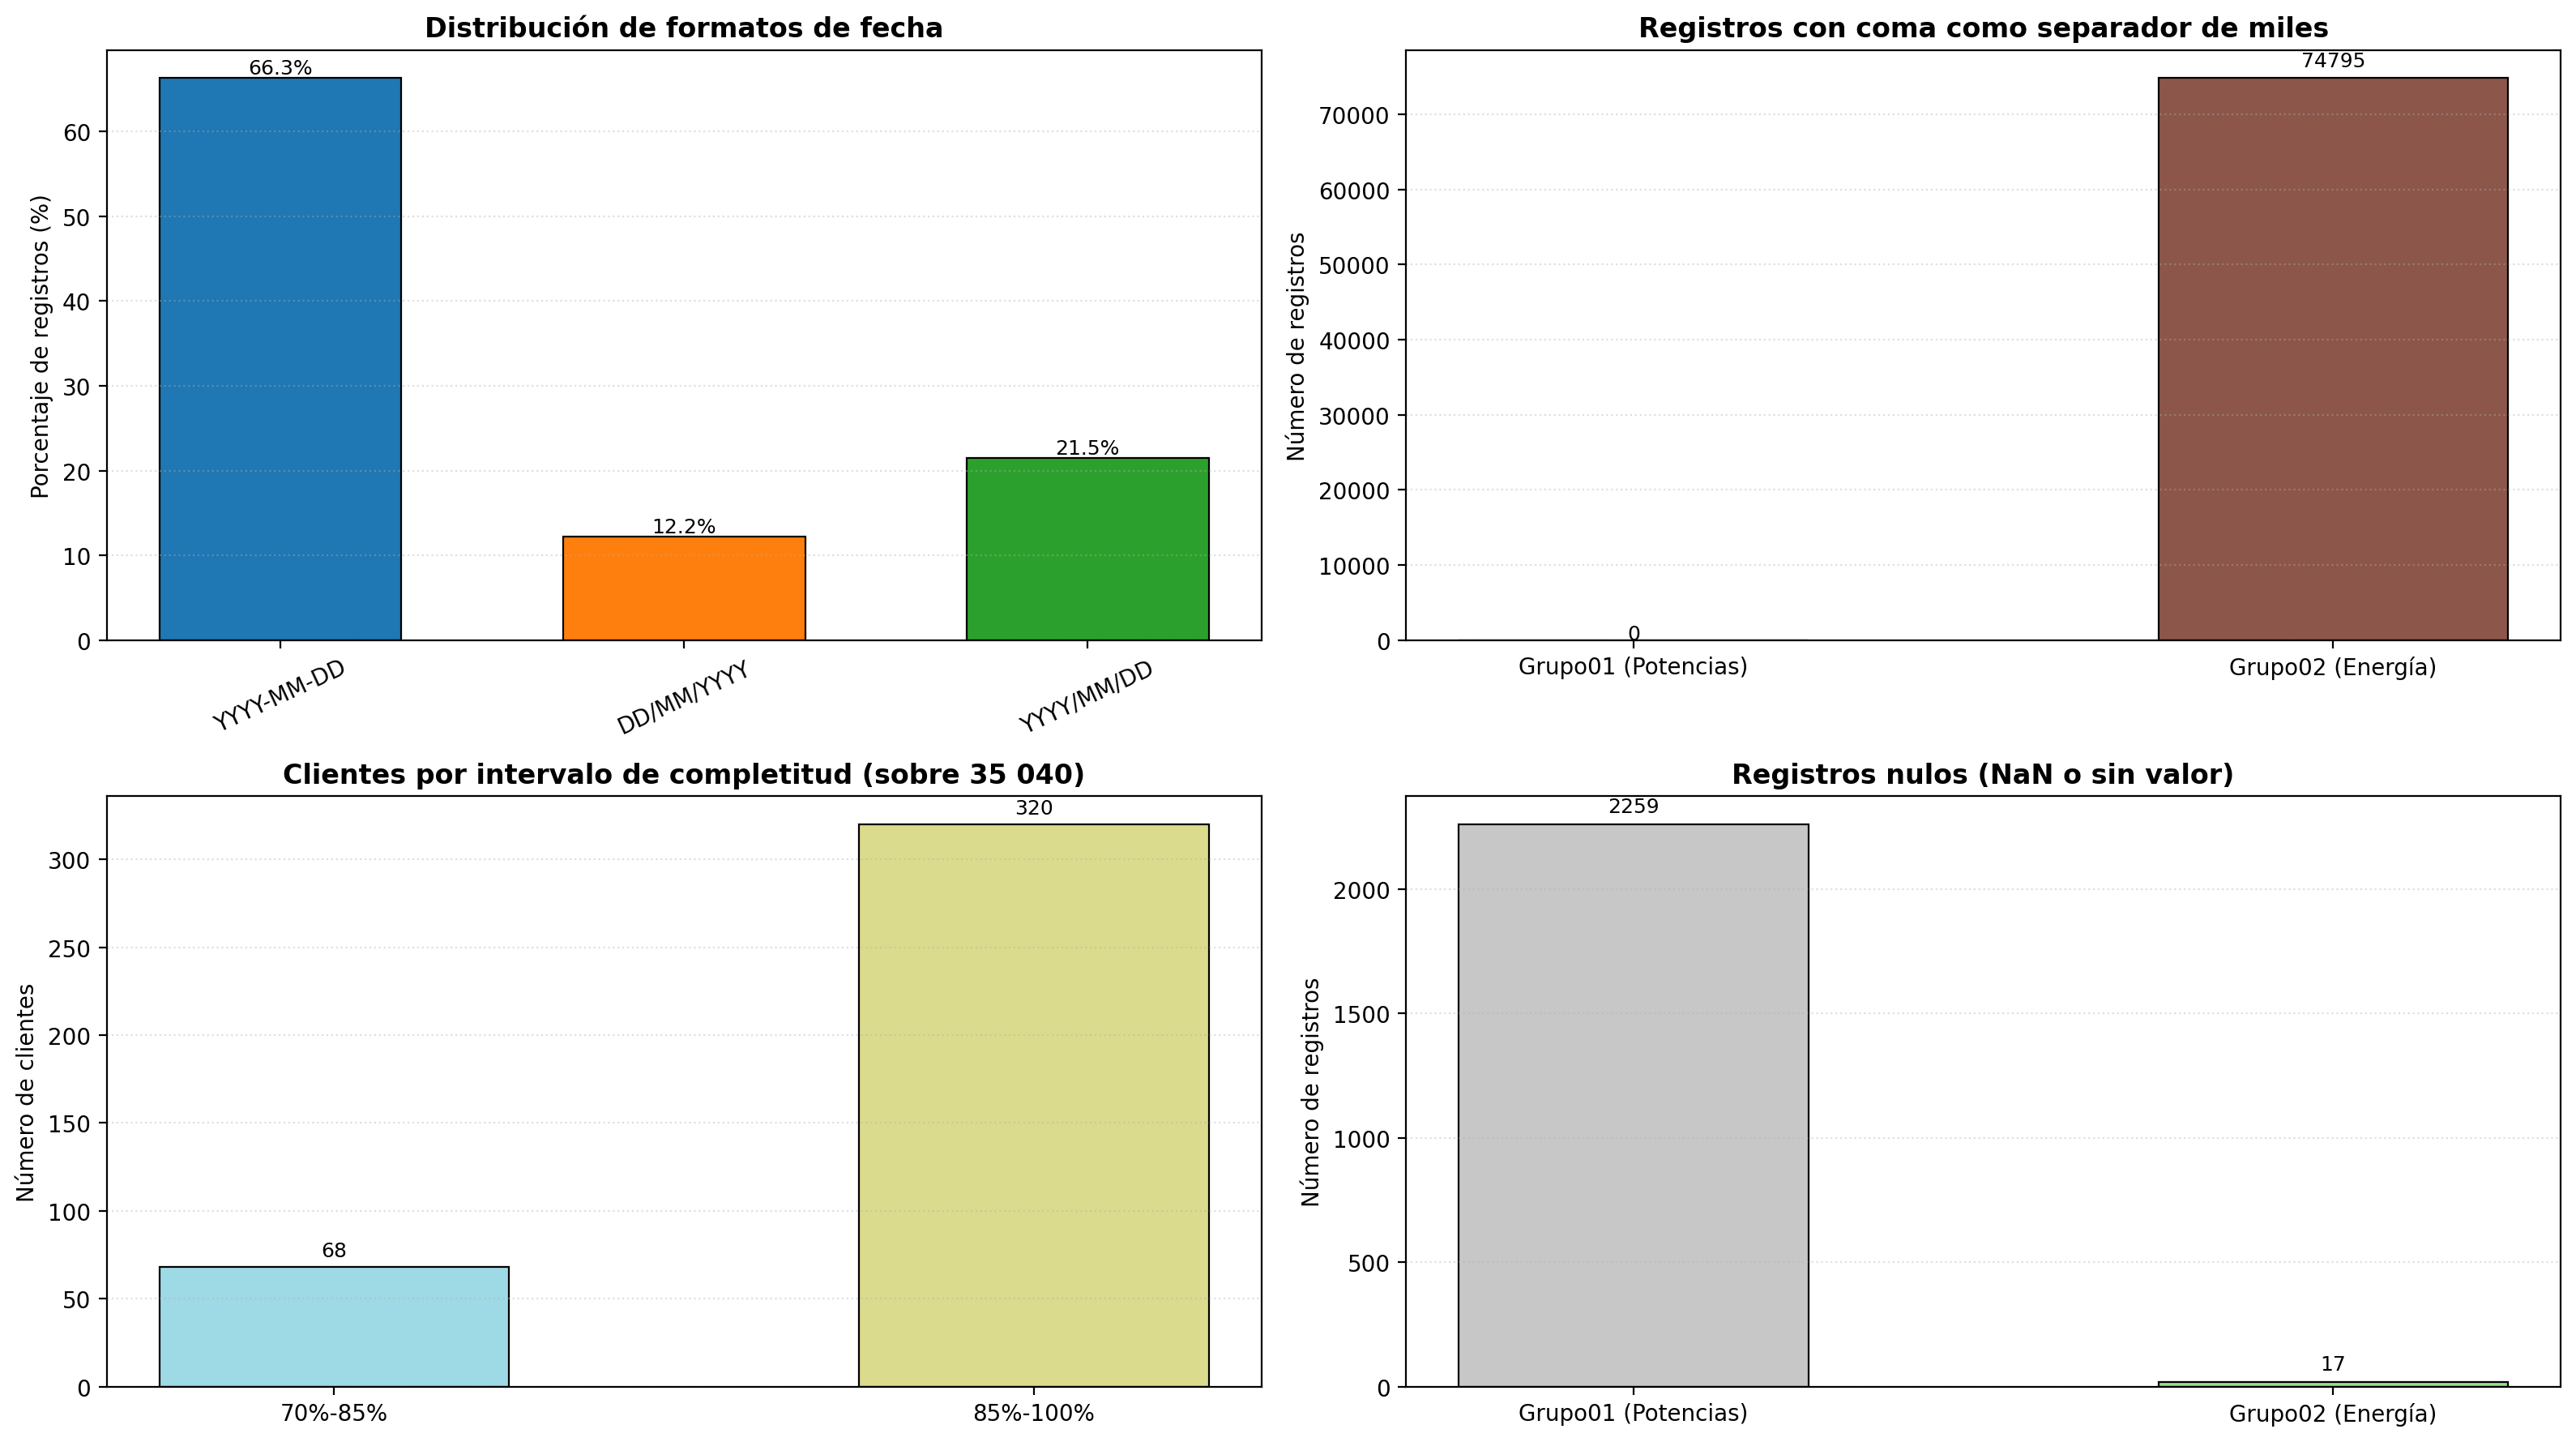

In [12]:
plot_verificacion_calidad_2x2(dict_dfs_clientes_g1, dict_dfs_clientes_g2)

## 3.- Comparación entre normalización anual y normalización por día

In [7]:
df_archivo_g2 = dict_dfs_clientes_g2['INT FOOD SERVICES CORP']

df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].astype("string")

# Eliminar registros que contienen el total
df_archivo_g2 = df_archivo_g2[~df_archivo_g2["Fecha"].str.contains("Total")]

# Eliminar los valores nulos en la columna 'Fecha'
df_archivo_g2 = df_archivo_g2.dropna(subset="Fecha")

# Separar para obtener columna Hora
df_archivo_g2["Hora"] = df_archivo_g2["Fecha"].apply(lambda x: x.split()[1].strip())

# Separar para obtener columna Fecha
df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].apply(lambda x: x.split()[0].strip())

# Eliminar duplicados y conservar el original del 2023
df_archivo_g2["Fecha-Hora"] = df_archivo_g2["Fecha"] + " " + df_archivo_g2["Hora"]
df_archivo_g2["Fecha-Hora"] = pd.to_datetime(df_archivo_g2["Fecha-Hora"], yearfirst=True)
df_archivo_g2 = df_archivo_g2.drop_duplicates(subset="Fecha-Hora", keep="first")

# Restar un timedelta de 15 a todas las fechas (Solo en este caso por que la ultima fecha)
# se pasa al siguiente mes
df_archivo_g2["Fecha-Hora"] = df_archivo_g2["Fecha-Hora"] - pd.Timedelta(minutes=15)

# Separar nuevamente para obtener columna Hora
df_archivo_g2["Hora"] = df_archivo_g2["Fecha-Hora"].astype("string").apply(lambda x: x.split()[1][:-3].strip())

# Separar nuevamente para obtener columna Fecha
df_archivo_g2["Fecha"] = df_archivo_g2["Fecha-Hora"].astype("string").apply(lambda x: x.split()[0].strip())

# Transformar la columna Fecha a un formato único
df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].apply(fecha_formato_unico)

# Debido a que a veces se ponen datos del 2024 para reemplazar los faltantes del 2023
# debemos descartar la fecha 29 de febrero, pues en 2023 no existe
df_archivo_g2 = df_archivo_g2[df_archivo_g2["Fecha"] != "2023/02/29"]

# Transformar columna Fecha a datetime
df_archivo_g2["Fecha"] = pd.to_datetime(df_archivo_g2["Fecha"], format='%Y/%m/%d')

# Limpiar la columna 'SE (KVah)'
df_archivo_g2["AS (kWh)"] = df_archivo_g2["AS (kWh)"].astype("string").str.replace(",", "").replace('"','')
df_archivo_g2["AS (kWh)"] = df_archivo_g2["AS (kWh)"].astype("float")

# Obtener la potencia aparente
df_archivo_g2["Potencia_aparente"] = df_archivo_g2["AS (kWh)"] * 4

# Eliminar días feriados y días de fin de semana
df_archivo_g2 = df_archivo_g2[~df_archivo_g2['Fecha'].isin(feriados_nacionales) & ~df_archivo_g2['Fecha'].dt.weekday.isin([5, 6])]

# Interpolar valores nulos usando una función polinomial
df_archivo_g2["Potencia_aparente"] = df_archivo_g2["Potencia_aparente"].interpolate(method='cubicspline')

# Conservar solo las columnas de interés
df_archivo_g2 = df_archivo_g2[["Fecha", "Hora", "Potencia_aparente"]]

# Copiar para normalizaciones diferentes
df_norm_anual = df_archivo_g2.copy()
df_norm_diaria = df_archivo_g2.copy()

# Obtener las coordenadas de cada curva tipo respectivmanete
df_curva_norm_diaria = obtener_curva_norm_diaria(df_norm_diaria)
df_curva_norm_global = obtener_curva_norm_anual(df_norm_anual)


In [11]:
def obtener_curva_norm_diaria(df_procesado):
    df_procesado["Potencia_aparente_escalada"] = df_procesado.groupby("Fecha")["Potencia_aparente"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0
    )
    
    # Transformar a float32 para reducir consumo de memoria
    df_procesado["Potencia_aparente"] = df_procesado["Potencia_aparente"].astype("float32")
    df_procesado["Potencia_aparente_escalada"] = df_procesado["Potencia_aparente_escalada"].astype("float32")
    
    # Obtener coordenadas de la curva tipo con los datos normalizados DIARAMENTE
    df_grouped = obtener_coords_curva_tipo(df_procesado)
    
    return df_grouped


def obtener_curva_norm_anual(df_procesado):
    df_procesado["Potencia_aparente_escalada"] = mmscaler.fit_transform(df_procesado[["Potencia_aparente"]])
    
    # Transformar a float32 para reducir consumo de memoria
    df_procesado["Potencia_aparente"] = df_procesado["Potencia_aparente"].astype("float32")
    df_procesado["Potencia_aparente_escalada"] = df_procesado["Potencia_aparente_escalada"].astype("float32")
    
    # Obtener coordenadas de la curva tipo con los datos normalizados ANUALMENTE
    df_grouped = obtener_coords_curva_tipo(df_procesado)
    
    return df_grouped

def graficar_curvas_tipo_comparadas(df_curva_norm_diaria, df_curva_norm_global, titulo=None):
    _ = plt.figure(figsize=(13, 6))
    _ = plt.plot(df_curva_norm_diaria['Hora'], df_curva_norm_diaria['Potencia_aparente_escalada'], label="Curva tipo - Normalización por día", linestyle="--")
    _ = plt.plot(df_curva_norm_global['Hora'], df_curva_norm_global['Potencia_aparente_escalada'], label="Curva tipo - Normalización global",   linestyle="--")
    _ = plt.xticks(df_curva_norm_diaria["Hora"].values[::2], rotation=45)
    _ = plt.yticks(np.arange(0, 1.1, 0.1))
    _ = plt.xlabel("Hora")
    _ = plt.ylabel("Potencia aparente escalada")
    if titulo:
        _ = plt.title(titulo)
    else:
        _ = plt.title("Curva tipo: comparación entre normalización global vs. por día")
    _ = plt.legend()
    #_ = plt.grid(True, alpha=0.3)
    _ = plt.tight_layout()
    _ = plt.grid(True, alpha=0.6)
    _ = plt.savefig(rf'{ruta_imgs_latex}/curva_tipo_norm_diaria_vs_global.png', format='png',dpi=400)
    _ = plt.show()
    


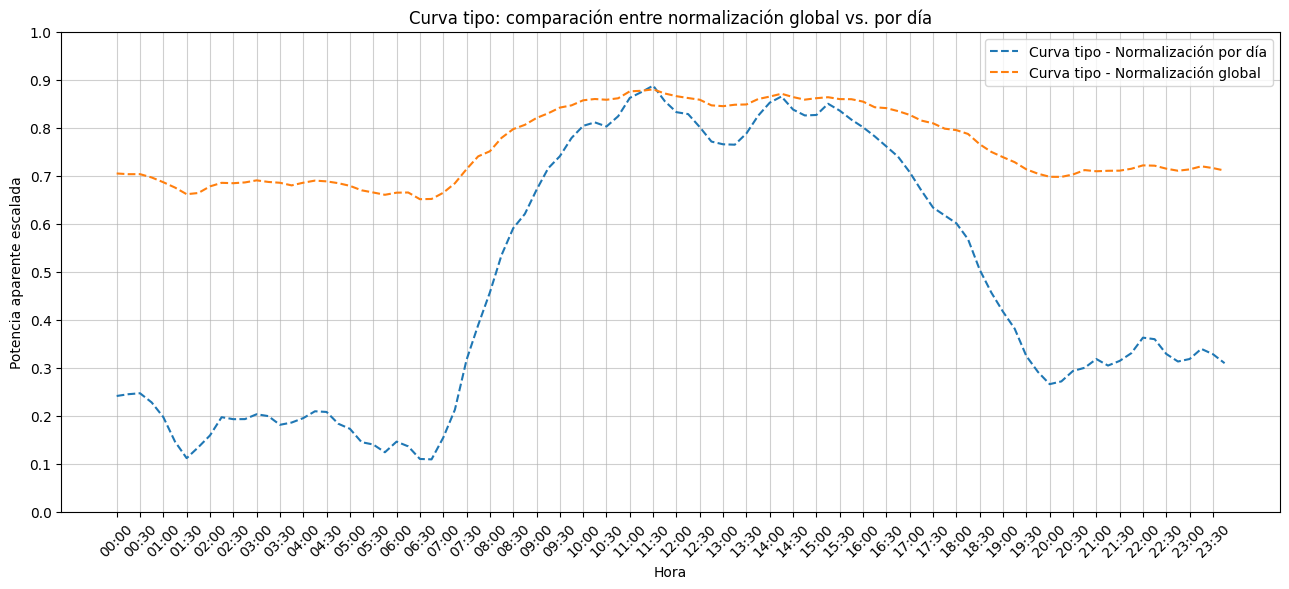

In [12]:
graficar_curvas_tipo_comparadas(df_curva_norm_diaria, df_curva_norm_global)

## 4.- Importancia del ajuste realizado a las curvas para comparabilidad

In [4]:
# Obtener cliente para conectar a la db
db_cliente = obtener_cliente_db()

# Obtener los registros de las curvas
cursor = db_cliente.CurvasTipo.CurvasTipoAnuales.find({}, {"_id": 0})
df_registros_curvas = pd.DataFrame(list(cursor))
df_registros_curvas_filt = df_registros_curvas[df_registros_curvas['Cliente'].isin(['10020880','90000338','1813455'])]

In [5]:
df_registros_curvas_filt

,Cliente,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,02:00,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
61,1813455,0.434830,0.427452,0.416194,0.418307,0.407893,0.422880,0.417981,0.414721,0.411928,...,0.335774,0.366464,0.439763,0.456388,0.461558,0.472068,0.463427,0.472887,0.461304,0.461037
121,90000338,0.058038,0.056804,0.058824,0.058053,0.054054,0.055556,0.058053,0.055556,0.055556,...,0.193215,0.166667,0.157895,0.142857,0.142857,0.130435,0.111111,0.083333,0.081633,0.071429
264,10020880,0.244363,0.273511,0.252374,0.250347,0.238424,0.241378,0.242008,0.241807,0.221186,...,0.294245,0.305108,0.293337,0.281768,0.283002,0.297126,0.259970,0.269353,0.256184,0.258848


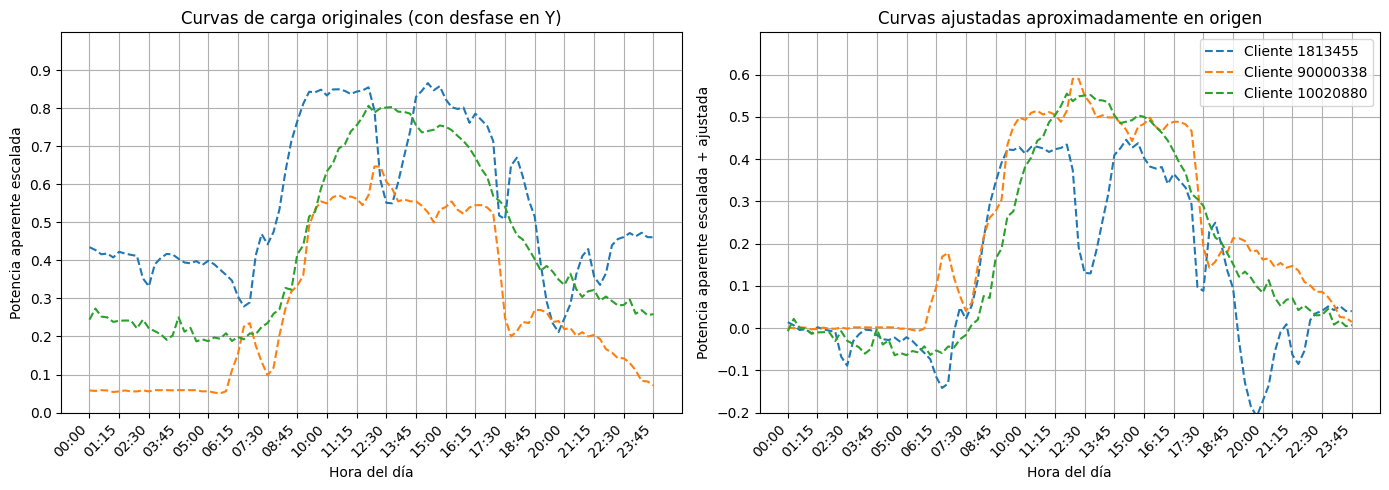

In [29]:
def ajustar_curva_origen2(datos_curvas, n=5):

    # Crear una copia del arreglo original de las curvas
    curvas_ajustadas = datos_curvas.copy()

    # Iterar sobre cada curva
    for curva in curvas_ajustadas:
        # Obtener el primer dato de cada curva
        sum_n = 0
        for i in range(n):
            sum_n += curva[i]
        
        valor_restar = sum_n / n

        # Modificar los datos de la curva para que el primero siempre empiece en (0,0)
        for i in range(len(curva)):
            curva[i] = curva[i] - valor_restar

    # Retornar todas las curvas con el ajuste realizado
    return curvas_ajustadas

# Columnas temporales (excluyendo 'Cliente')
cols_tiempo = df_registros_curvas_filt.columns[1:]
n = len(cols_tiempo)

# --- Curvas originales ---
curvas_originales = {
    row['Cliente']: row[cols_tiempo].astype(float).values
    for _, row in df_registros_curvas_filt.iterrows()
}

# --- Curvas ajustadas simétricas a [0,1] ---
curvas_ajust = ajustar_curva_origen2(df_registros_curvas_filt[cols_tiempo].values[:,0:])
curvas_ajustadas = {cliente: curvas_ajust[i]
                    for i, cliente in enumerate(list(df_registros_curvas_filt['Cliente'].values))}

# Vector X numérico (0..n-1)
x = np.arange(n)

# Ticks cada 2 horas (8 puntos de 15 min)
tick_pos = np.arange(0, n, 5)
tick_lab = cols_tiempo[::5].tolist()

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Antes (escala real)
for cliente, y in curvas_originales.items():
    axs[0].plot(x, y, label=f'Cliente {cliente}', linestyle='--')
axs[0].set_title('Curvas de carga originales (con desfase en Y)')
axs[0].set_xlabel('Hora del día')
axs[0].set_ylabel('Potencia aparente escalada')
axs[0].grid(True)
#axs[0].legend()

# Después (simétrico [0,1])
for cliente, y in curvas_ajustadas.items():
    axs[1].plot(x, y, label=f'Cliente {cliente}', linestyle='--')
axs[1].set_title('Curvas ajustadas aproximadamente en origen')
axs[1].set_xlabel('Hora del día')
axs[1].set_ylabel('Potencia aparente escalada + ajustada')
axs[1].grid(True)
axs[1].legend()

# Ticks X en ambos
for i, ax in enumerate(axs):
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_lab, rotation=45, ha='right')
    if i == 0:
        ax.set_yticks(np.arange(0, 0.95, 0.1))
        ax.set_ylim(0, 1)
    else:
        ax.set_yticks(np.arange(-0.2, 0.65, 0.1))
        ax.set_ylim(-0.2, 0.70)

#fig.supxlabel('Hora del día')

plt.tight_layout()

plt.savefig(rf'{ruta_imgs_latex}/cm_curvas_sinajustar_vs_ajustada.png', format='png',dpi=400)

plt.show()
